In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
pd.options.display.max_rows = 999

In [3]:
prices = 100 + np.cumsum(np.random.normal(size=365*3))

In [4]:
with open('prices.npy', 'rb') as f:
    prices = np.load(f)

In [5]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def timeseries_to_training_set(a, set_size):
    x_size = set_size - 1
    out_samples_size = a.shape[0] - x_size
    X = np.zeros((out_samples_size, x_size))
    y = np.zeros((out_samples_size, 1))
    for i, x in enumerate(rolling_window(a, set_size)):
        X[i] = x[:-1]
        y[i] = x[-1]
    return X, y

In [6]:
poly_window = 5

X, y = timeseries_to_training_set(prices, poly_window + 1)

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
print(reg.score(X, y), reg.coef_)

0.9911288931237598 [[-0.00139296 -0.02830463 -0.04037159  0.03838669  1.027701  ]]


In [8]:
predicted = np.dot(X, reg.coef_.T)
pp = np.concatenate((np.full((poly_window,1), predicted[0][0]), predicted))

Text(0,0.5,'Price (USD)')

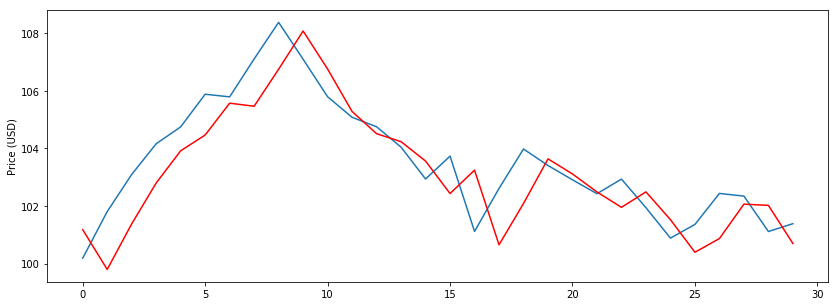

In [9]:
plt.rcParams['figure.figsize'] = [14, 5]

plt.plot(prices[poly_window:][:30])
plt.plot(pp[poly_window:][:30], 'r')

plt.ylabel('Price (USD)')

In [11]:
def f(p):
    return np.dot(p, reg.coef_.T)
#     return (p[0] * reg.coef_[0][0] + 
#             p[1] * reg.coef_[0][1] +
#             p[2] * reg.coef_[0][2] +
#             p[3] * reg.coef_[0][3] +
#             p[4] * reg.coef_[0][3] +
#             p[5] * reg.coef_[0][3])

def sim_strategy(prices):
    UNITS_TO_TRADE = 100

    invested_units = 0
    invested_capital = 0
    max_capital_required = 0
    profit = 0
    trades = 0

    for i in range(0, len(prices) - poly_window + 1):
        expected_price = f(prices[i:][:poly_window])
        todays_price = prices[i + poly_window - 1]

        if expected_price > todays_price:
            # Buy
            invested_units += UNITS_TO_TRADE
            invested_capital += todays_price * UNITS_TO_TRADE
            max_capital_required = max(max_capital_required, invested_capital)
            trades += 1
        elif (todays_price * invested_units) >= invested_capital:
            # Sell
            profit += (todays_price * invested_units) - invested_capital
            invested_units = 0
            invested_capital = 0

    return trades, profit, max_capital_required, invested_capital

N = 100
avg_metrics = [0, 0, 0, 0]
for i in range(N):
    prices = 100 + np.cumsum(np.random.normal(size=365*3))
    metrics = sim_strategy(prices)
    for i in range(4):
        avg_metrics[i] += metrics[i]

for i in range(4):
    avg_metrics[i] /= N

avg_trades, avg_profit, avg_max_capital_required, avg_invested_capital = avg_metrics
    
print("Trades: {}\n"
      "Total profit: {:3.2f}\n"
      "Profit per trade: {:3.2f}\n"
      "Capital required: {:3.2f}\n"
      "Return on capital: {:3.2f}%\n"
      "Remaining invested capital: {:3.2f}"
      .format(avg_trades,
              avg_profit,
              avg_profit / avg_trades,
              avg_max_capital_required,
              (avg_profit * 100) / (avg_max_capital_required),
              avg_invested_capital))

# Trades: 760.729
# Total profit: 363281.97
# Profit per trade: 477.54
# Capital required: 5131082.67
# Return on capital: 7.08%
# Remaining invested capital: 3631095.72

Trades: 0.56
Total profit: 21.72
Profit per trade: 38.79
Capital required: 1007.18
Return on capital: 2.16%
Remaining invested capital: 506.69
